## Velocity to galaxy overdensity

Estimating the velocity of a galaxy based on its overdensity can be somewhat tricky, as this requires solving the differential equation $$\nabla \cdot \vec{v} + f\nabla\cdot[(\vec{v}\cdot\hat{n})\hat{n}] = -aHf\frac{\delta_g}{b}.$$ On the other hand, calculating the galaxy overdensity based on the velocities is rather simple as this does not require solving a differential equation, but simply filling in the formula. To do this, we need an estimation of the derivatives of the velocities, for which we use the five point stencil.

In [1]:
import my_functions as mf
import numpy as np
from scipy.stats import binned_statistic
from matplotlib import pyplot as plt

In [2]:
dmo = mf.LoadSimulation('/net/hydra/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5')
dmo.selext_galaxies_mass_threshold([10**11, np.inf])
dmo.load_all(128)

Mass range: 11.0 - inf
Galaxies: 7009562


/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:101: RuntimeWarning: invalid value encountered in divide
  voxel_velocity = voxel_velocity_summation / voxel_count


A common approximation for $f$ is $$f=\Omega_m^\gamma,$$where $\gamma \approx 0.55$.

In [3]:
f = dmo.data.metadata.cosmology.Om0**.55
aH = dmo.data.metadata.cosmology.H(0).value  # if z = 0

In [4]:
def schaan_formula_binned(voxel_velocities: np.ndarray, faH: float, boxsize: float, bins: np.ndarray) -> tuple[np.ndarray,np.ndarray]:
    """Formula 6 from Schaan et al. (2021). This function predicts the galaxy overdensity in each voxel, given the voxel velocities.

    Args:
        voxel_velocities (np.ndarray): array with dimension (3, Nbins, Nbins, Nbins) containing the average velocity of each voxel in three dimensions
        faH (float): f * a * H. This value acts as the normalization of the formula
        boxsize (float): box size in Mpc
        bins (np.ndarray): array containing the galaxy overdensity bin edges used in binned_statistic

    Returns:
        out (tuple[np.ndarray,np.ndarray]):
        - **x** (np.ndarray): bin centers of binned_statistic
        - **v_mean** (np.ndarray): mean voxel velocity within a galaxy overdensity bin
    """
    #dvx, dvy, dvz = five_point_stencil(voxel_velocities, voxelsize)
    dvx = mf.five_point_stencil(voxel_velocities[0], boxsize, 0)
    dvy = mf.five_point_stencil(voxel_velocities[1], boxsize, 1)
    dvz = mf.five_point_stencil(voxel_velocities[2], boxsize, 2)

    delta = (dvx + dvy + dvz + f * dvx) / - faH    # Not corrected for bias

    v = np.sum(voxel_velocities**2, axis=0)**.5    # Combine v_x, v_y and v_z
    v_mean = binned_statistic(delta.flatten(), v.flatten(), statistic='mean', bins=bins)[0]

    return (bins[1:] + bins[:-1])/2, v_mean

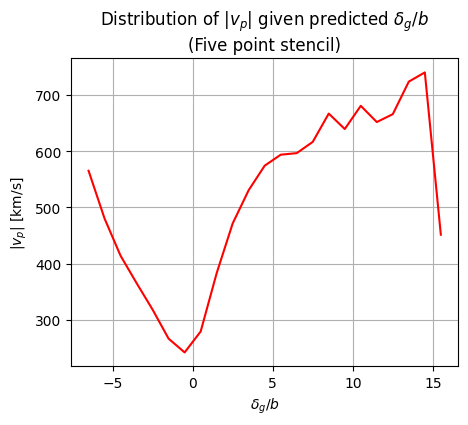

In [5]:
fig, ax = plt.subplots(1,1,figsize=[5,4])
x, y = schaan_formula_binned(dmo.voxel_velocity, f*aH, 1000, np.arange(-20, 20))
ax.plot(x, y, c='r')
ax.set(
    xlabel=r'$\delta_g/b$',
    ylabel=r'$|v_p|$ [km/s]',
    title='Distribution of $|v_p|$ given predicted $\\delta_g/b$\n(Five point stencil)',
)
ax.grid()

plt.show()

Note that $\delta_g$ cannot go below -1 (and the bias is approximately unity). However, since this formula should only be used to calculate the velocity based on the overdensity and not the other way around, finding values of $\delta_g < -1$ is not a serious problem.